# Import

In [1]:
import numpy as np
from scipy.stats import norm
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import statistics
from scipy import signal, stats
import scipy.fftpack
from cycler import cycler

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
#%matplotlib notebook

# Data structure

In [3]:
N_scal = 256
simulations = [{'Sc': 400.0, 'N': N_scal, 'u': 2.0, 'folder' : 'u2/', 'runs': [71], 'D0': 1.6106299160107476E-003}, 
        {'Sc': 400.0, 'N': N_scal, 'u': 2.5, 'folder' : 'u25/', 'runs': [60], 'D0': 2.0132873950134342E-003}, 
        {'Sc': 400.0, 'N': N_scal, 'u': 3.0, 'folder' : 'u3/', 'runs': [48], 'D0': 2.4159448740161214E-003}, 
        {'Sc': 400.0, 'N': N_scal, 'u': 3.25, 'folder' : 'u325/', 'runs': [44], 'D0': 2.6172736135174650E-003},
        {'Sc': 400.0, 'N': N_scal, 'u': 3.5, 'folder' : 'u35/', 'runs': [41], 'D0': 2.8186023530188085E-003},
        {'Sc': 400.0, 'N': N_scal, 'u': 3.75, 'folder' : 'u375/', 'runs': [46], 'D0': 3.0199310925201517E-003},
        {'Sc': 400.0, 'N': N_scal, 'u': 4.0, 'folder' : 'u4/', 'runs': [38], 'D0': 3.2212598320214953E-003},
        {'Sc': 400.0, 'N': N_scal, 'u': 4.07, 'folder' : 'u407/', 'runs': [35], 'D0': 3.2776318790818716E-003}]

In [4]:
eps = 4.0/3.0
viscosity = 1.0

In [5]:
for sim in range(len(simulations)) :
    simulations[sim].update({'diffusivity': viscosity/simulations[sim]["Sc"]})

# Reading data

In [6]:
#read correlation files
def read_data_file(common_folder, scalar, file_type, spec_type, spec_component, run_files) :
    nb_of_runs = len(run_files)
    for run_index in list(range(nb_of_runs)) :
        folder = common_folder + "run" + "%01d" % (run_index+1) + "/"
        if (run_files[run_index] < 1000) :
            file = folder + "scalar%01d" %scalar + "_" + file_type + "_" + spec_type + "_C" + spec_component + "_wi=" + "%03d" % run_files[run_index] + ".table"
        else : 
            file = folder + file_type + "_" + spec_type + "_C" + spec_component + "_wi=" + "%06d" % run_files[run_index] + ".table"
        file_data = []
        print('reading file: ' + file)
        averaging_weight = (run_files[run_index]+1)/(sum(run_files)+nb_of_runs)
        for line in open(file) :
            temp_array_line = []
            if line[0] == '#' :          #skip commented lines
                continue
            else :
                temp_array_line=list(map(float, line.split( )))
                temp_array_line = [t * averaging_weight for t in temp_array_line]
                file_data.append(temp_array_line)  
        if (run_index == 0) : 
            accumulated_data = file_data.copy()
        else : 
            accumulated_data = list(map(lambda l1, l2: [sum(x) for x in zip(l1, l2)], accumulated_data, file_data))
    k = np.array(accumulated_data[0])
    nb_of_modes = np.array(accumulated_data[1])
    average_data = np.ndarray(shape=(len(accumulated_data)-2, k.shape[0]+1), dtype=float)
    for i in list(range(average_data.shape[0])) : 
        average_data[i, :] = np.array(accumulated_data[i+2])
    t = average_data[:,0]
    numpy_file_table = np.array(average_data[:,1:])
    return [k, nb_of_modes, t, numpy_file_table]

In [7]:
# read velocity spectrum file
def read_spec_file(common_folder, forlder_in, quantity, spec_type, ite) :
    file = common_folder + forlder_in + quantity + "_spec_" + spec_type + "_ite=%06d" % ite + ".table"
    print('reading file: ' + file)
    file_data = []
    for line in open(file) :
        temp_array_line = []
        if line[0] == '#' :          #skip commented lines
            continue
        else :
            temp_array_line=list(map(float, line.split( )))
            file_data.append(temp_array_line)  
    spec_table = np.array(file_data)
    k = spec_table[:,0]
    nb_of_modes = spec_table[:,1]
    Ek = spec_table[:,2]
    Exx = spec_table[:,3]
    Eyy = spec_table[:,4]
    Ezz = spec_table[:,5]
    #return [k, nb_of_modes, Ek, Exx, Eyy, Ezz, spec_table[:,6], spec_table[:,7], spec_table[:,8], spec_table[:,9]]
    return [k, nb_of_modes, Ek]

In [8]:
common_folder = "/home/gorbunov8a/data/random_advection/e43/N256/"
spec_type = "lin"
spec_component = "avg"
sca = 1
file_type = "two_point_corr_complex"

In [9]:
# read data files
for simu in simulations : 
    [k, nb_of_modes, time, two_point_corr] = read_data_file(common_folder + simu['folder'], sca, file_type, spec_type, spec_component, simu['runs'])
    simu.update({'corr': two_point_corr})
    simu.update({'t': time})

reading file: /home/gorbunov8a/data/random_advection/e43/N256/u2/run1/scalar1_two_point_corr_complex_lin_Cavg_wi=071.table
reading file: /home/gorbunov8a/data/random_advection/e43/N256/u25/run1/scalar1_two_point_corr_complex_lin_Cavg_wi=060.table
reading file: /home/gorbunov8a/data/random_advection/e43/N256/u3/run1/scalar1_two_point_corr_complex_lin_Cavg_wi=048.table
reading file: /home/gorbunov8a/data/random_advection/e43/N256/u325/run1/scalar1_two_point_corr_complex_lin_Cavg_wi=044.table
reading file: /home/gorbunov8a/data/random_advection/e43/N256/u35/run1/scalar1_two_point_corr_complex_lin_Cavg_wi=041.table
reading file: /home/gorbunov8a/data/random_advection/e43/N256/u375/run1/scalar1_two_point_corr_complex_lin_Cavg_wi=046.table
reading file: /home/gorbunov8a/data/random_advection/e43/N256/u4/run1/scalar1_two_point_corr_complex_lin_Cavg_wi=038.table
reading file: /home/gorbunov8a/data/random_advection/e43/N256/u407/run1/scalar1_two_point_corr_complex_lin_Cavg_wi=035.table


In [10]:
# [k_vel, nb_of_modes_vel, Ek] = read_spec_file(common_folder, "run2/", "vel", "lin", 80000)

# Parameters

In [11]:
# Plotting options
plt.rc('axes', labelsize=16)  
plt.rc('axes', titlesize=16)  
plt.rc('legend', fontsize=14)  

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
default_cycler = cycler(cycler(linestyle=['-', '--', ':', '-.'])*cycler(color=colors))
plt.rc('axes', prop_cycle=default_cycler)

In [12]:
kmin = 8
kmax = np.max(k)-6
nb_of_curves = 9
step = round((kmax - kmin)/nb_of_curves)
indices_of_k_to_plot = np.arange(kmin,kmax,step, dtype=np.int16)
print(indices_of_k_to_plot)

[  8  21  34  47  60  73  86  99 112]


# Spectra

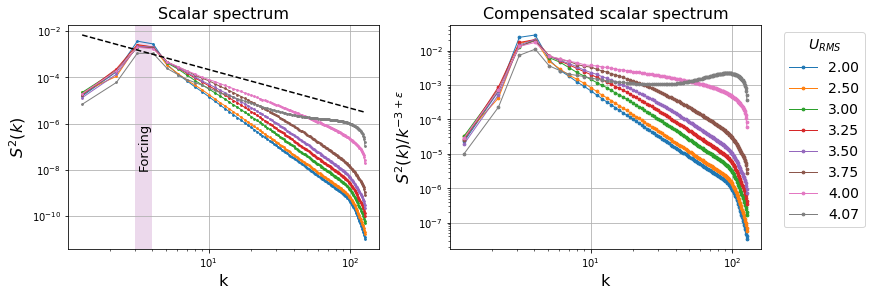

In [13]:
fig, ax = plt.subplots(ncols=2, nrows=1, constrained_layout=True, figsize=(12,4))
#for sca in range(len(scalars)) :
for simu in simulations :
    ax[0].plot(k, (simu["corr"][0,:]*4.0*np.pi*(k**2)), '.-', lw=1.0, markersize=3.5)
    ax[1].plot(k, (simu["corr"][0,:]*4.0*np.pi*(k**2))/(k**(-3+eps)), '.-', lw=1.0, markersize=5.5, label=r'%2.2f' % simu['u'])
ax[0].plot(k,10e-3*k**(-3+eps), 'k--')
ax[0].axvspan(3.0, 4.0, facecolor='purple', alpha=0.15)
ax[0].text(3.5, 10e-8, "Forcing", {'color': 'black', 'fontsize': 13},
         horizontalalignment='center',
         verticalalignment='center',
         rotation=90,
         clip_on=False)
ax[0].set(xscale='log', yscale='log', xlabel='k', ylabel=r'$S^2(k)$', title=r'Scalar spectrum'); ax[0].grid()
#ax[0].set(ylim=[10e-13,10e-4])

#ax[1].plot(k,4e-5*np.ones_like(k), 'k--', lw=1.5)
ax[1].set(xscale='log', yscale='log', xlabel='k', ylabel=r'$S^2(k)/k^{-3+\epsilon}$', title=r'Compensated scalar spectrum'); ax[1].grid()
#ax[1].set(ylim=[10e-7,5e-3])
lgd = ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=r'$U_{RMS}$', title_fontsize=14)

# pp = PdfPages('../Images/Scalar/spec_scalar_compens_eps05_N256_one_diff2.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()

plt.show()

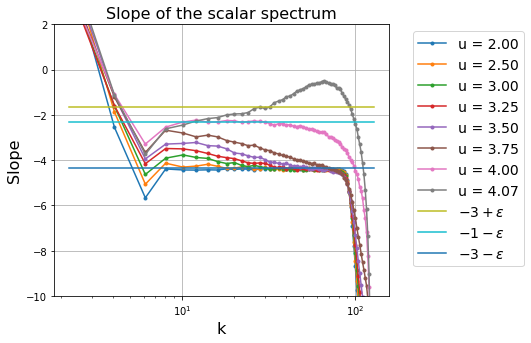

In [14]:
# check the slope of the mean energy
resampling = 2
x = np.log(k[1::resampling])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,5))
for simu in simulations :
    slope = np.gradient(np.log((simu["corr"]*4.0*np.pi*(k**2))[0,1::resampling]), x)
    ax.plot(np.exp(x), slope, '.-', label=r'u = %2.2f' % simu['u'])
ax.plot(np.exp(x), np.full_like(x, (-3.0+eps), dtype=float), '-', label=r'$-3+\epsilon$')
ax.plot(np.exp(x), np.full_like(x, (-1.0-eps), dtype=float), '-', label=r'$-1-\epsilon$')
ax.plot(np.exp(x), np.full_like(x, (-3.0-eps), dtype=float), '-', label=r'$-3-\epsilon$')

ax.set(xscale='log', yscale='linear', title='Slope of the scalar spectrum', xlabel='k', ylabel='Slope'); ax.grid()
ax.set(ylim=[-10,2])
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# 2-point time correlations

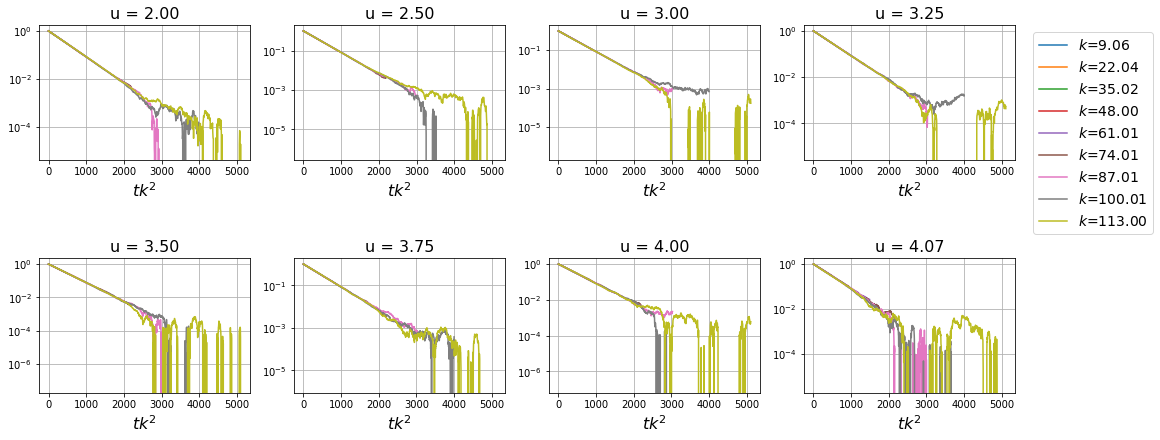

In [15]:
fig, ax = plt.subplots(nrows=2, ncols=4, constrained_layout=True,figsize=(16,6), squeeze=False)
for i in range(len(simulations)) :
    simu = simulations[i]
    row = i//4; col = i - (row*4)
    corr = simu['corr']
    for ik in indices_of_k_to_plot :
        ax[row,col].plot(simu['t']*k[ik]**2, corr[:,ik]/corr[0,ik], '-', label=r'$k$=%2.2f' % (k[ik]))
    ax[row,col].set(xscale='linear',yscale='log', xlabel=r'$t k^2$', title=r'u = %2.2f' % simu['u']); ax[row,col].grid()
ax[0,3].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Fit

In [32]:
tk2_end_fit = 1500.0
for simu in simulations :
    simu['lin_trend'] = np.zeros_like(k, dtype=float)
    simu['intercept'] = np.zeros_like(k, dtype=float)
    a = 0 
    b = np.searchsorted(simu['t']*k[ik]**2, tk2_end_fit)
    for ik in list(range(len(k))) : 
        simu['lin_trend'][ik], simu['intercept'][ik], r_value, p_value, std_err = \
        stats.linregress(simu['t'][a:b], np.log(simu['corr'][a:b,ik]/simu['corr'][0,ik]))

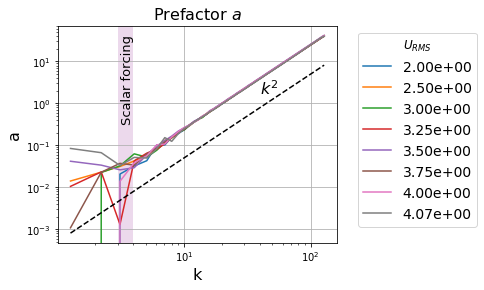

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
for simu in simulations :
    ax.plot(k, -1.0*simu['lin_trend'], '', label=r'%2.2e' % simu['u'])
ax.plot(k, 5e-4*k**2, 'k--')
ax.annotate(r'$k^2$', xy=(40, 1.6e0), xycoords='data', size='16')
ax.set(xscale='log', yscale='log', xlabel='k', ylabel='a', title='Prefactor $a$'); ax.grid()
#ax.set(ylim=[5e2,10e6])
#ax.annotate(r'diffusivity', xy=(50, 6e5),  xycoords='data', xytext=(50, 1.6e3), textcoords='data', arrowprops=dict(facecolor='black', width=0.25), size='14', horizontalalignment='center', verticalalignment='top')
plt.axvspan(3.0, 4.0, facecolor='purple', alpha=0.15)
plt.text(0.25, 0.75, "Scalar forcing", {'color': 'black', 'fontsize': 13},
         horizontalalignment='center',
         verticalalignment='center',
         rotation=90,
         clip_on=False,
         transform=plt.gca().transAxes)
lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=r'$U_{RMS}$', title_fontsize=12)
#ax.legend(title=r'Diffusivity $\kappa$', title_fontsize=12)

# pp = PdfPages('Images/Scalar/correlation_fit_eps05_N256.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()

plt.show()

In [34]:
def find_plateau(data) :
    N = len(data)
    Nmin = N//2
    a = 0; b = N-1
    minAlign = np.max(data-np.mean(data))/np.float(b-a+1)
    for i in list(range(0, N-Nmin-1)) :
        for j in list(range(i+Nmin, N-1)) :
            newAlign = np.max(data[i:j]-np.mean(data[i:j]))/np.float(j-i+1)
            if (newAlign < minAlign) :
                minAlign = newAlign
                a = i; b = j
    return np.mean(data[a:b]), np.std(data[a:b]), (b-a+1), a, b

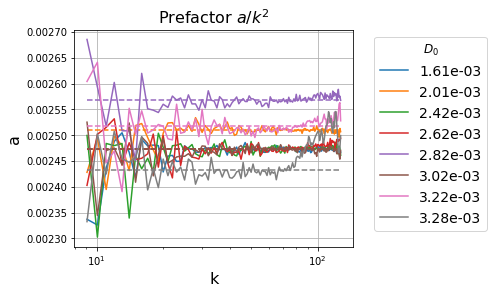

In [50]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
sl = np.s_[8:-1]
for i in range(len(simulations)) :
    simu = simulations[i]
    ax.plot(k[sl], -1.0*simu['lin_trend'][sl]/(k[sl]**2), '', label=r'%2.2e' % simu['D0'], color=colors[i])
    ax.plot(k[sl], np.full_like(k[sl], find_plateau(-1.0*simu['lin_trend'][sl]/(k[sl]**2))[0]), '--', color=colors[i])
ax.set(xscale='log', yscale='linear', xlabel='k', ylabel='a', title='Prefactor $a/k^2$'); ax.grid()
lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=r'$D_0$', title_fontsize=12)
#ax.legend(title=r'Diffusivity $\kappa$', title_fontsize=12)

# pp = PdfPages('Images/Scalar/correlation_fit_eps05_N256.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()

plt.show()

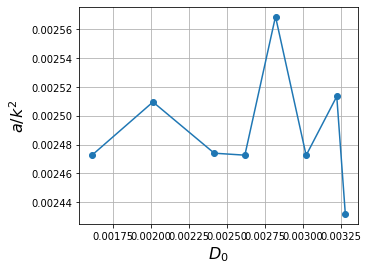

In [47]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
x = np.array([simu['D0'] for simu in simulations])
y = [find_plateau(-1.0*simu['lin_trend'][sl]/(k[sl]**2))[0] for simu in simulations]
ax.plot(x,y, 'o-')
ax.set(xlabel=r'$D_0$', ylabel=r'$a/k^2$'); ax.grid()
plt.show()